<a href="https://colab.research.google.com/github/AdityaPunetha/ML-Projects/blob/main/TensorFlow-Variational-Autoencoder-MNIST/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
import tensorflow.keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, Layer
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Data

In [3]:
(x_train, y_train), (x_test, y_test) = load_data()

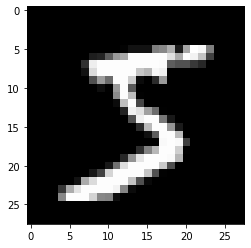

In [4]:
plt.imshow(x_train[0],cmap = 'gray')

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [6]:
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 #MNIST --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

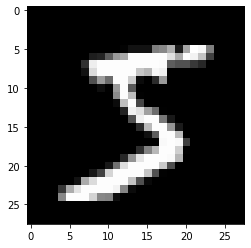

In [7]:
plt.imshow(x_train[0][:,:,0],cmap = 'gray')

# Model

In [8]:
latent_dim = 2

## Encoder

In [9]:
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

In [10]:
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

## Functions

In [11]:
z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

In [12]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [13]:
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

In [14]:
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

## Decoder

In [15]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# Need to start with a shape that can be remapped to original image shape as
#we want our final utput to be same shape original input.
#So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshape to the shape of last conv. layer in the encoder, so we can 
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
#Can add more conv2DTranspose layers, if desired. 
#Using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

In [16]:
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       18464     
 nspose)                                                         
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289       
 pose)                                                           
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable

In [17]:
z_decoded = decoder(z)

## Custom loss

In [18]:
class CustomLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [19]:
y = CustomLayer()([input_img, z_decoded])

## Vae

In [20]:
vae = Model(input_img, y, name='vae')

In [21]:
vae.compile(optimizer='adam', loss=None)

In [22]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                                

# Train

In [23]:
vae.fit(x_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
47808/48000 [============================>.] - ETA: 0s - loss: 0.2322

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 16s 332us/sample - loss: 0.2321 - val_loss: 0.2045
Epoch 2/10
48000/48000 [==============================] - 9s 185us/sample - loss: 0.2004 - val_loss: 0.1970
Epoch 3/10
48000/48000 [==============================] - 8s 176us/sample - loss: 0.1954 - val_loss: 0.1932
Epoch 4/10
48000/48000 [==============================] - 9s 186us/sample - loss: 0.1923 - val_loss: 0.1915
Epoch 5/10
48000/48000 [==============================] - 10s 201us/sample - loss: 0.1901 - val_loss: 0.1892
Epoch 6/10
48000/48000 [==============================] - 11s 224us/sample - loss: 0.1883 - val_loss: 0.1879
Epoch 7/10
48000/48000 [==============================] - 10s 205us/sample - loss: 0.1871 - val_loss: 0.1874
Epoch 8/10
48000/48000 [==============================] - 9s 182us/sample - loss: 0.1860 - val_loss: 0.1862
Epoch 9/10
48000/48000 [==============================] - 9s 185us/sample - loss: 0.1852 - val_loss: 0.1857
Epoch 10/10
48000/48000 [==========

# Eval

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


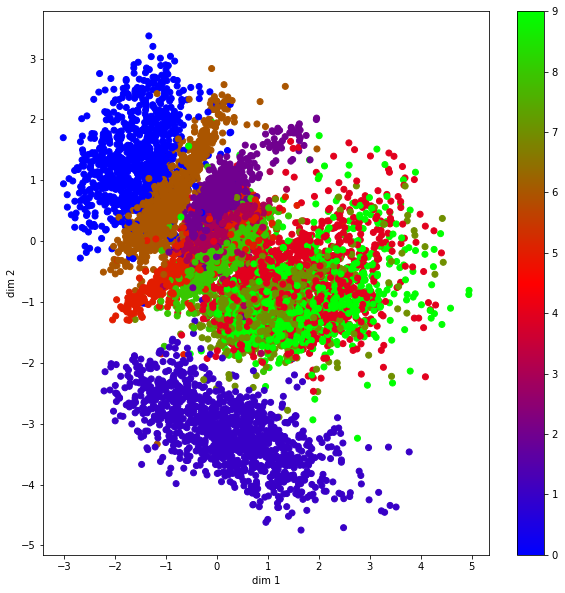

In [24]:
mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

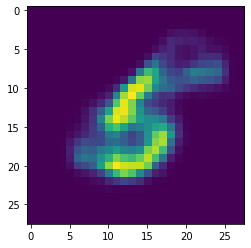

In [34]:
sample_vector = np.array([[-1.5,-0.6]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

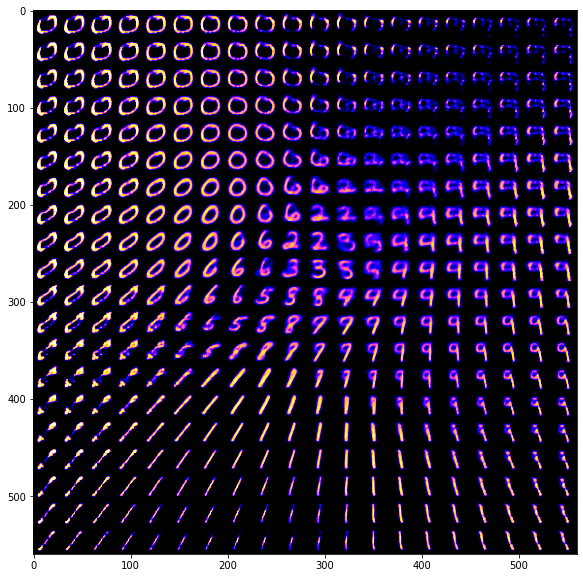

In [35]:
n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  

# Save

In [36]:
vae.save('variational_autoencoder_mnist_vae')

ValueError: ignored

In [37]:
decoder.save('variational_autoencoder_mnist_decoder')

In [38]:
encoder.save('variational_autoencoder_mnist_encoder')

In [39]:
!zip -r /content/variational_autoencoder_mnist_decoder.zip /content/variational_autoencoder_mnist_decoder

  adding: content/variational_autoencoder_mnist_decoder/ (stored 0%)
  adding: content/variational_autoencoder_mnist_decoder/keras_metadata.pb (deflated 89%)
  adding: content/variational_autoencoder_mnist_decoder/assets/ (stored 0%)
  adding: content/variational_autoencoder_mnist_decoder/saved_model.pb (deflated 89%)
  adding: content/variational_autoencoder_mnist_decoder/variables/ (stored 0%)
  adding: content/variational_autoencoder_mnist_decoder/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/variational_autoencoder_mnist_decoder/variables/variables.index (deflated 45%)


In [40]:
!zip -r /content/variational_autoencoder_mnist_encoder.zip /content/variational_autoencoder_mnist_encoder

  adding: content/variational_autoencoder_mnist_encoder/ (stored 0%)
  adding: content/variational_autoencoder_mnist_encoder/keras_metadata.pb (deflated 92%)
  adding: content/variational_autoencoder_mnist_encoder/assets/ (stored 0%)
  adding: content/variational_autoencoder_mnist_encoder/saved_model.pb (deflated 89%)
  adding: content/variational_autoencoder_mnist_encoder/variables/ (stored 0%)
  adding: content/variational_autoencoder_mnist_encoder/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/variational_autoencoder_mnist_encoder/variables/variables.index (deflated 60%)
